In [20]:
# python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import astropy as ap
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

# lenstronomy imports
from lenstronomy.Util import util
from lenstronomy.Util import mask_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Workflow.fitting_sequence import FittingSequence

In [4]:
# get filenames from desktop
filepath = '/Users/gilliancartwright/Desktop/summerproject/' # my personal filepath
filename = filepath + 'Right_detectable_Jack_complete (1).fits'

In [5]:
# Get data from fits files:

def get_data(filename, coadd_id):  
    """Input filename and coadd_id returns fwhm of g,r,i bands and image data"""
    hdu_list = fits.open(filename)
    data = pd.DataFrame(hdu_list[2].data) # get dataframe data
    image = hdu_list['IMAGE'].data # get image data
    # drop unused columns 
    # note: this makes a new data frame so you can still access the original data with all columns if needed
    data_df = data.drop(columns=['HPIX_16384','HPIX_4096', 'KRON_RADIUS', 'GAP_FLUX_G',
                             'RANK', 'MOF_BDF_FLUX_G', 'MOF_PSF_FLUX_G', 'SOF_BDF_FLUX_G',
                            'SOF_PSF_FLUX_G', 'IMAFLAGS_ISO_G', 'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I',
                             'IMAFLAGS_ISO_Z', 'MEM_MATCH_ID', 'ACT', 'BBNA', 'BNA', 'TI', 
                            'RNA', 'RNA2', 'REDM', 'REDM_MISSED', 'SPTPOL', 'PROB', 
                             'FWHM_WMEAN_Z', 'SKYBRITE_WMEAN_Z', 'FLUX_RADIUS_G', 'FLUX_RADIUS_R',
                             'FLUX_RADIUS_I', 'FLUX_RADIUS_Z', 'TILENAME', 'MAG_AUTO_G', 'MAG_APER_4_G',
                             'MAG_APER_8_G', 'SOF_BDF_G_1', 'SOF_BDF_G_2', 'SKYBRITE_WMEAN_G', 
                            'SKYBRITE_WMEAN_R', 'SKYBRITE_WMEAN_I'], axis=1)   
    hdu_list.close() # close
    
    return data_df, image


In [6]:
# Reference Image
def plot_image(g,r,i):
      
    # combine into one image:
    image_data = ap.visualization.make_lupton_rgb(i, r, g, stretch = 50, Q = 10)
    
    # set fig and axes
    fig, ax = plt.subplots()
    ax.imshow(image_data, origin = 'lower')
    
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('RGB Image')

    # show and close image
    plt.show()
    plt.close()

# Reference image for a single band
def plot_band(band):
    image_data = band
    fig, ax = plt.subplots()
    ax.imshow(image_data, origin = 'lower')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.show()
    plt.close()

In [7]:
# Data Specifics
background_rms = 7.  #  background noise per pixel 
exp_time = 90.  #  exposure time 
numPix = 45  #  cutout pixel size per axis
deltaPix = 0.2637  #  pixel size in arcsec
psf_type = 'GAUSSIAN' 

In [21]:
def model(mask, coadd_id, kwargs_lens_initial, kwargs_source_initial, kwargs_lens_light_initial):
    
    # get data from fits file
    data_df, image = get_data(filename, coadd_id)
    row = data_df[data_df['COADD_OBJECT_ID'] == coadd_id].index[0]
    
    # separate image data for each band
    g = image[row,0,:,:]
    r = image[row,1,:,:]
    i = image[row,2,:,:]

    # get fwhm data
    fwhm_g = data_df.iloc[row,8]
    fwhm_r = data_df.iloc[row,9]
    fwhm_i = data_df.iloc[row,10] 
    
    # set models to use
    lens_model_list = ['SIE', 'SHEAR']
    source_model_list = ['SERSIC_ELLIPSE']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    
    # generate the coordinate grid and image properties
    ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

    # generate the psf variables for each band
    kwargs_psf_g = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_g, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_psf_r = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_r, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_psf_i = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_i, 'pixel_size': deltaPix, 'truncation': 3}
    
    # set numerics
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

    # generate image data for each band
    kwargs_data_g = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC
               'image_data': g}  # 2d data vector
    
    kwargs_data_r = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  
               'image_data': r}  
    
    kwargs_data_i = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord, 
               'image_data': i} 
    
    # Optional: add mask
    # Note: mask must be entered as dictionary in the form:
    # mask = {'mask_center_x': _, 'mask_center_y': _, 'mask_radius': _}
    if mask:
        # generate mask
        ra_grid_2d, dec_grid_2d = util.array2image(ra_grid), util.array2image(dec_grid)
        mask_2d = mask_util.mask_center_2d(center_x=mask.get('mask_center_x'), center_y=mask.get('mask_center_y'), 
                                           r=mask.get('mask_radius'), x_grid=ra_grid_2d, y_grid=dec_grid_2d)
        # plot mask to check
        plt.figure()
        plt.imshow(mask_2d, origin='lower', cmap='gray', alpha=0.5)
        plt.show()
        plt.close()
        
        # add mask to each band
        def add_mask(band, kwargs_data, kwargs_psf):
            """ 
            Input: band (g,r,i), corresponding kwargs_data and kwargs_psf for band
            Output: updated kwargs_data for the band with mask applied
            """
            # apply mask
            data_class = ImageData(**kwargs_data)
            psf_class = PSF(**kwargs_psf)
            imageFit = ImageLinearFit(data_class = data_class, 
                                  psf_class=psf_class,
                                  kwargs_numerics=kwargs_numerics, 
                                  likelihood_mask=mask_2d)
            mask_1d = imageFit.image2array_masked(band)
            masked_image = imageFit.array_masked2image(mask_1d)
            
            # plots the image with mask for reference 
            plt.figure()
            plt.imshow(masked_image, origin='lower', cmap='gray', alpha=0.5)
            plt.show()
            plt.close()
            
            # update kwargs_data with masked image
            kwargs_data = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  
               'image_data': masked_image}  
            
            return kwargs_data
        
        kwargs_data_g = add_mask(g, kwargs_data_g, kwargs_psf_g)
        kwargs_data_r = add_mask(r, kwargs_data_r, kwargs_psf_r)
        kwargs_data_i = add_mask(i, kwargs_data_i, kwargs_psf_i)
    
    elif mask == None:
        pass
    else:
        pass
    
    
    ### create model
    # lens models             
    fixed_lens = []
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    fixed_lens.append({})  # for this example, we fix the power-law index of the lens model to be isothermal
    kwargs_lens_init.append(kwargs_lens_initial) 
    kwargs_lens_sigma.append({'theta_E': .4, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.05, 'center_y': 0.05})
    kwargs_lower_lens.append({'theta_E': 1., 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_lens.append({'theta_E': 7., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})


    fixed_lens.append({'ra_0': 0, 'dec_0': 0})
    kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.})
    kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
    kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})


    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

    fixed_source = []
    kwargs_source_init = []
    kwargs_source_sigma = []
    kwargs_lower_source = []
    kwargs_upper_source = []


    fixed_source.append({})
    kwargs_source_init.append(kwargs_source_initial)
    kwargs_source_sigma.append({'n_sersic': 1, 'R_sersic': 0.5, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.5, 'center_y': 0.5})
    kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -2, 'center_y': -2})
    kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 2, 'center_y': 2})

    source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


    fixed_lens_light = []
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []


    fixed_lens_light.append({})
    kwargs_lens_light_init.append(kwargs_lens_light_initial) 
    kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.5, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.5, 'center_y': 0.5})
    kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -2, 'center_y': -2})
    kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 2, 'center_y': 2})

    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

    kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}
    
    ### fitting process
    kwargs_likelihood = {'source_marg': False}
    kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 'lens_light_model_list': lens_light_model_list}

    multi_band_list = [[kwargs_data_g, kwargs_psf_g, kwargs_numerics], 
                       [kwargs_data_r, kwargs_psf_r, kwargs_numerics], 
                       [kwargs_data_i, kwargs_psf_i, kwargs_numerics]]
    
    kwargs_data_joint = {'multi_band_list': multi_band_list, 
                         'multi_band_type': 'multi-linear'}  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.     
    kwargs_constraints = {}
    
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 20, 'n_iterations': 20}],
                       ['MCMC', {'n_burn': 20, 'n_run': 60, 'walkerRatio': 10, 'sigma_scale': .1}]]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    
    ### plot RGB, observed, model, and residuals
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
    f, axes = plt.subplots(1, 4, figsize=(16, 8), sharex=False, sharey=False)
    
    # make RGB image 
    rgb_data = ap.visualization.make_lupton_rgb(i, r, g, stretch = 50, Q = 10)
    axes[0].imshow(rgb_data, origin = 'lower')
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].text(0,40, 'RGB Image', color="w", backgroundcolor='k', fontsize = 14)
    
    modelPlot.data_plot(ax=axes[1])
    modelPlot.model_plot(ax=axes[2])
    modelPlot.normalized_residual_plot(ax=axes[3], v_min=-6, v_max=6)

    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
    plt.show()
    plt.close()
    
    ### Check Einstein Radius Results
    # print COADD_ID for reference:
    print(f'COADD_OBJECT_ID: {coadd_id}')
    
    # print the real Einstein Radius from the data table
    theta_E_real = data_df.iloc[row,6]
    theta_E_err = data_df.iloc[row,7]
    print(f'The expected Einstein radius is {theta_E_real}  +-  {theta_E_err}')
    
    # print Einstein radius that was fit by the model
    theta_E_model = kwargs_result.get('kwargs_lens')[0].get('theta_E')
    print(f'The Einstein radius from the model is {theta_E_model}')

In [12]:
# set initial guesses

kwargs_lens_initial = {'theta_E': 3.5, 'e1': 0.05, 'e2': -0.05,'center_x': 0., 'center_y': 0.}
kwargs_source_initial = {'R_sersic': 1, 'n_sersic': 1, 'e1': -0.1, 'e2': -0.1, 'center_x': 0., 'center_y': 0.}
kwargs_lens_light_initial = {'R_sersic': 4, 'n_sersic': 5, 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0}

Computing the PSO ...
10
20
Max iteration reached! Stopping.
-0.5976650085876015 reduced X^2 of best position
-1807.9366509774945 logL
6050 effective number of data points
[{'theta_E': 3.7577844379241534, 'e1': 0.08415166632699661, 'e2': 0.02705659512637746, 'center_x': 0.009536148991041224, 'center_y': -0.030537854179895588}, {'gamma1': -0.05316258433037066, 'gamma2': -0.10327194052494518, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.8804972676928169, 'n_sersic': 1.5161640535417549, 'e1': -0.4934828162998573, 'e2': -0.10271030003679378, 'center_x': -0.29386860280156757, 'center_y': 0.4190989526636737}] source result
[{'amp': 1, 'R_sersic': 3.6016572503736826, 'n_sersic': 4.462149203925996, 'e1': 0.003880368099355756, 'e2': -0.004924166504220497, 'center_x': -0.07893150975305596, 'center_y': 0.10699458306676563}] lens light result
[] point source result
{} special param result
1.0948538780212402 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [00:51<00:00,  1.54it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  20
Sampling iterations (in current run): 80
52.53041386604309 time taken for MCMC sampling
-0.36560577137740097 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.12347167027892196
reduced chi^2 of data  1 =  0.25530195119252824
reduced chi^2 of data  2 =  0.7180436926607527


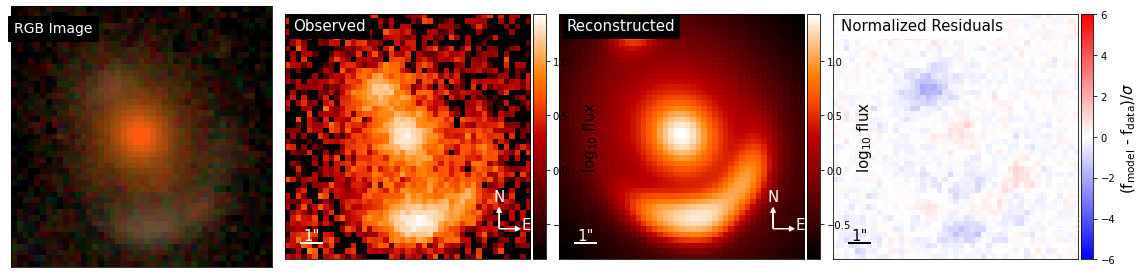

COADD_OBJECT_ID: 1015396778
The expected Einstein radius is 3.6402021  +-  0.4953744
The Einstein radius from the model is 4.27277471016008


In [13]:
# test model:

model(coadd_id = 1015396778, mask = None,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.42171836435711524 reduced X^2 of best position
-1275.6980521802736 logL
6050 effective number of data points
[{'theta_E': 1.8432341357816344, 'e1': 0.33094560088228364, 'e2': -0.299222895696312, 'center_x': 0.04598803789570029, 'center_y': 0.4092787123752616}, {'gamma1': -0.19996629347088635, 'gamma2': 0.05394871726255562, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.5821364689937925, 'n_sersic': 4.993006614565488, 'e1': -0.28572717502225947, 'e2': 0.0015777337330688916, 'center_x': 1.1299946607609805, 'center_y': -0.035107118100241926}] source result
[{'amp': 1, 'R_sersic': 4.749643237892819, 'n_sersic': 4.998123411240937, 'e1': 0.20756931021699904, 'e2': -0.045414308553897643, 'center_x': -0.2492159382198218, 'center_y': 0.035827201922889775}] lens light result
[] point source result
{} special param result
85.61490082740784 time used for  

100%|████████████████████████████████████████████| 800/800 [06:21<00:00,  2.10it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
382.1772549152374 time taken for MCMC sampling
-0.4195464389386852 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.0878455682368499
reduced chi^2 of data  1 =  0.2108869665907554
reduced chi^2 of data  2 =  0.9599067819884504


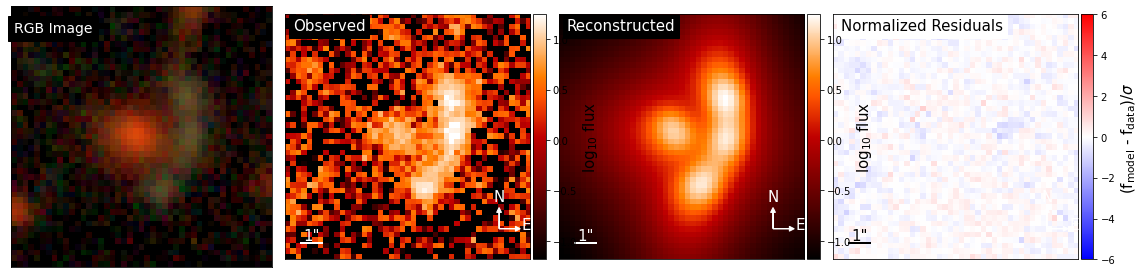

COADD_OBJECT_ID: 1194748640
The expected Einstein radius is 2.46834629  +-  0.37378494
The Einstein radius from the model is 1.9618717088557611


In [9]:
# COADD = 1194748640

kwargs_lens_initial2 = {'theta_E': 3, 'e1': 0.05, 'e2': -0.05,'center_x': 0., 'center_y': 0.}
kwargs_source_initial2 = {'R_sersic': 1, 'n_sersic': 1, 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0.}
kwargs_lens_light_initial2 = {'R_sersic': 4, 'n_sersic': 4, 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0}

model(coadd_id = 1194748640, mask= None,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)


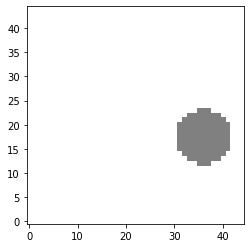

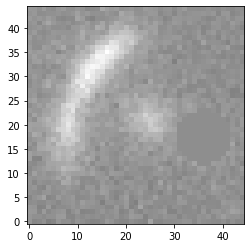

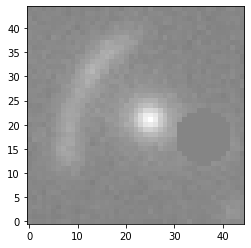

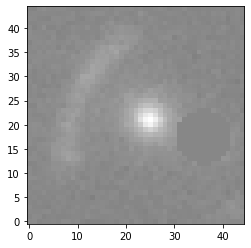

Computing the PSO ...
10
20
Max iteration reached! Stopping.
-0.8353799707411503 reduced X^2 of best position
-2527.0244114919797 logL
6050 effective number of data points
[{'theta_E': 3.537723390057173, 'e1': 0.3279397457750108, 'e2': -0.0005803407204718397, 'center_x': -0.07001929347232545, 'center_y': 0.046888674190383166}, {'gamma1': -0.1760636684056987, 'gamma2': 0.0548341235354943, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.3520660011633516, 'n_sersic': 2.208520136600469, 'e1': -0.10236562028836271, 'e2': -0.0641355448275123, 'center_x': -1.2202171851047758, 'center_y': -0.652176380464069}] source result
[{'amp': 1, 'R_sersic': 4.306892551229051, 'n_sersic': 4.287505207091881, 'e1': -0.025245730692400267, 'e2': -0.15362214684414646, 'center_x': 0.6428013217295444, 'center_y': -0.18946982276818816}] lens light result
[] point source result
{} special param result
1.0653948783874512 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [00:53<00:00,  1.49it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  20
Sampling iterations (in current run): 80
54.44779992103577 time taken for MCMC sampling
-0.3989775080368365 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.09164141905834654
reduced chi^2 of data  1 =  0.25951777447248237
reduced chi^2 of data  2 =  0.845773330579681


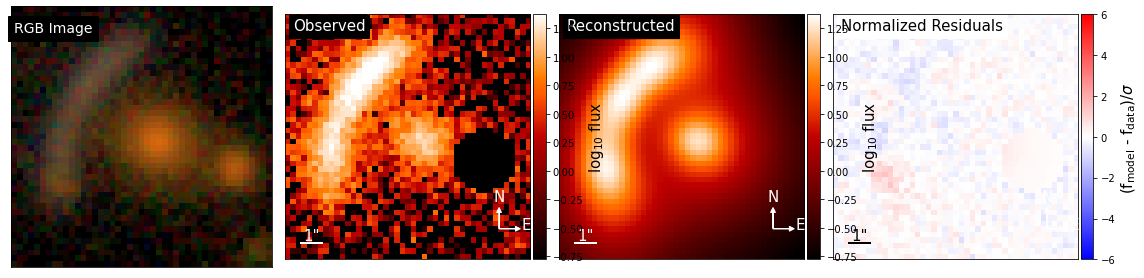

COADD_OBJECT_ID: 919882930
The expected Einstein radius is 3.70226639  +-  0.45413298
The Einstein radius from the model is 2.760892709789387


In [22]:
# COADD = 919882930 (with mask)

model(coadd_id = 919882930, mask = {'mask_center_x': 3.7, 'mask_center_y': -1.2, 'mask_radius': 1.5}, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.2316067329885266 reduced X^2 of best position
-700.610367290293 logL
6050 effective number of data points
[{'theta_E': 4.661708577503223, 'e1': 0.33918448067927376, 'e2': -0.10315518722362191, 'center_x': -0.12423123726763749, 'center_y': 0.5818059938598147}, {'gamma1': 0.07515497328509013, 'gamma2': 0.03985090652628511, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.33997195673186115, 'n_sersic': 0.8165777963974061, 'e1': 0.41498730147731805, 'e2': 0.15747880150066623, 'center_x': -0.2946033272470013, 'center_y': 1.9999873925230482}] source result
[{'amp': 1, 'R_sersic': 2.0535124949666677, 'n_sersic': 2.5308012885800157, 'e1': -0.07471184079123781, 'e2': -0.0006533498779962847, 'center_x': -0.009330041228452055, 'center_y': 0.04811192955238109}] lens light result
[] point source result
{} special param result
104.06435203552246 time used for 

100%|████████████████████████████████████████████| 800/800 [06:31<00:00,  2.04it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
391.9345152378082 time taken for MCMC sampling
-0.23120442367682198 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.05211378783649157
reduced chi^2 of data  1 =  0.13280551242164737
reduced chi^2 of data  2 =  0.5086939707723269


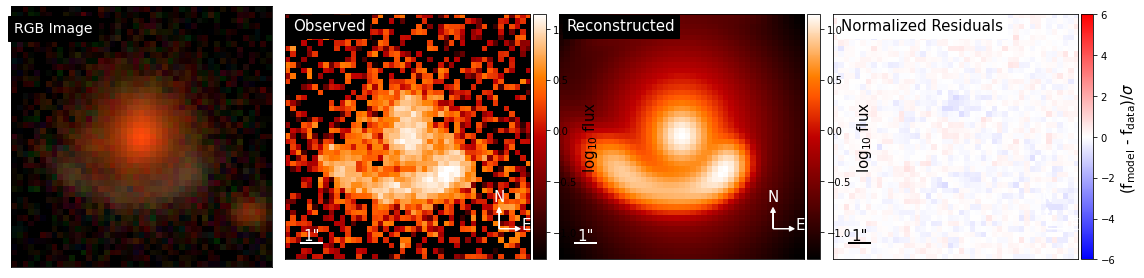

COADD_OBJECT_ID: 958711616
The expected Einstein radius is 3.15064048  +-  0.35580688
The Einstein radius from the model is 4.631705406767752


In [11]:
# COADD = 958711616

model(coadd_id = 958711616,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.16352986933529068 reduced X^2 of best position
-494.6778547392543 logL
6050 effective number of data points
[{'theta_E': 1.807834011719103, 'e1': -0.1302416914702637, 'e2': -0.3470927722997441, 'center_x': 0.21037230692448386, 'center_y': -0.2652849519253499}, {'gamma1': -0.084921237724662, 'gamma2': 0.16948542185802584, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.6613628680605446, 'n_sersic': 0.9817260139957084, 'e1': -0.20613956696904956, 'e2': -0.18056842448098157, 'center_x': -0.2818896987908111, 'center_y': 0.007695782070989587}] source result
[{'amp': 1, 'R_sersic': 3.6651726490853753, 'n_sersic': 4.881960345120255, 'e1': -0.058786448497203644, 'e2': -0.2426878497857269, 'center_x': 0.0871369667646038, 'center_y': -0.26315707571911556}] lens light result
[] point source result
{} special param result
151.98906183242798 time used for  P

100%|████████████████████████████████████████████| 800/800 [08:28<00:00,  1.57it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
508.95694184303284 time taken for MCMC sampling
-0.16331737923065553 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.07178669262306715
reduced chi^2 of data  1 =  0.12135336130195286
reduced chi^2 of data  2 =  0.2968120837669466


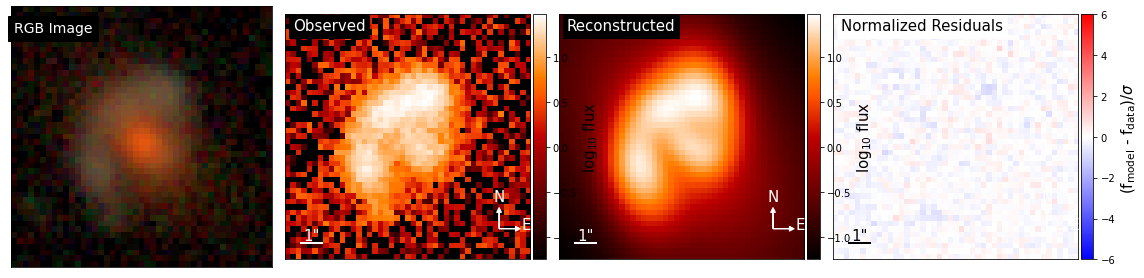

COADD_OBJECT_ID: 1193586965
The expected Einstein radius is 2.34239392  +-  0.352189
The Einstein radius from the model is 1.8125253091702254


In [20]:
#COADD = 1193586965

model(coadd_id = 1193586965,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.11936693663468369 reduced X^2 of best position
-361.08498331991814 logL
6050 effective number of data points
[{'theta_E': 2.519867633012865, 'e1': 0.306202734425171, 'e2': 0.1666085691518019, 'center_x': 0.2628573718505333, 'center_y': -0.00014882153234392607}, {'gamma1': -0.14407202737871688, 'gamma2': -0.07149725240304831, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.3400845096173255, 'n_sersic': 4.2162889665877765, 'e1': -0.25236504400035814, 'e2': -0.07379920388902896, 'center_x': -1.9999711633103276, 'center_y': -0.2869694877677152}] source result
[{'amp': 1, 'R_sersic': 2.7333329469792287, 'n_sersic': 4.195263463386544, 'e1': 0.10811426481481909, 'e2': 0.1462822443568283, 'center_x': 0.002525064545456877, 'center_y': -0.024792224907398627}] lens light result
[] point source result
{} special param result
133.71127605438232 time used for

100%|████████████████████████████████████████████| 800/800 [06:31<00:00,  2.04it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
392.3988108634949 time taken for MCMC sampling
-0.11820175466516056 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.039304542820603285
reduced chi^2 of data  1 =  0.08039760165964463
reduced chi^2 of data  2 =  0.23490311951523377


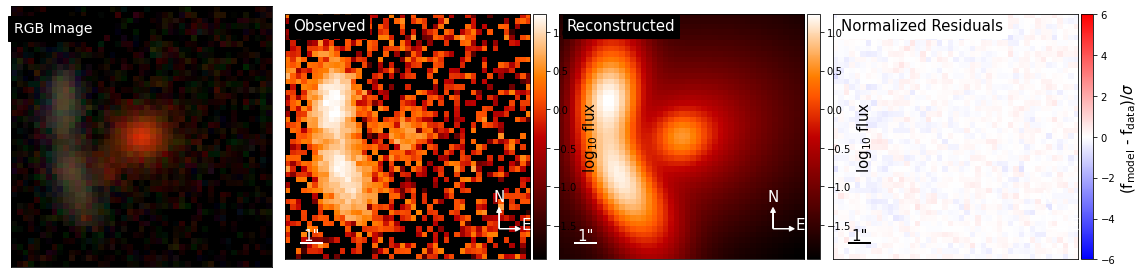

COADD_OBJECT_ID: 1215585225
The expected Einstein radius is 3.59165754  +-  0.30332179
The Einstein radius from the model is 2.6050962709951873


In [21]:
#COADD = 1215585225

model(coadd_id = 1215585225,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.2403290919439632 reduced X^2 of best position
-726.9955031304887 logL
6050 effective number of data points
[{'theta_E': 3.1112420566436327, 'e1': 0.07943175309805847, 'e2': -0.18342713360547994, 'center_x': -0.011600783069368941, 'center_y': 0.150848251058268}, {'gamma1': -0.012391028442791814, 'gamma2': 0.1222388908428193, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.18678931547692154, 'n_sersic': 4.997137884646933, 'e1': -0.15433143127097337, 'e2': 0.06888572697660163, 'center_x': -0.5674583871674086, 'center_y': 0.3981321995989423}] source result
[{'amp': 1, 'R_sersic': 2.8888063063759595, 'n_sersic': 4.999704921716352, 'e1': 0.023733818842765278, 'e2': -0.06972110647497468, 'center_x': -0.07119125104728616, 'center_y': 0.09328172195846665}] lens light result
[] point source result
{} special param result
104.8120551109314 time used for  P

100%|████████████████████████████████████████████| 800/800 [08:24<00:00,  1.59it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
505.37860107421875 time taken for MCMC sampling
-0.23876036075082616 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.07548955556394818
reduced chi^2 of data  1 =  0.1678255880062402
reduced chi^2 of data  2 =  0.4729659386822901


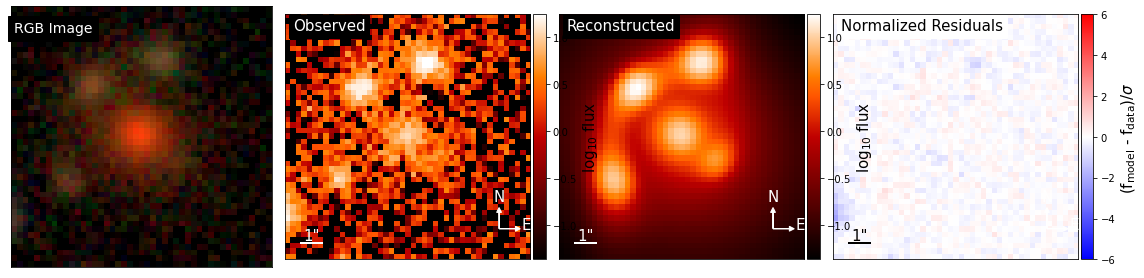

COADD_OBJECT_ID: 1076469675
The expected Einstein radius is 4.52519009  +-  1.84652374
The Einstein radius from the model is 3.134317754529153


In [22]:
#COADD = 1076469675

model(coadd_id = 1076469675,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.31956269591618225 reduced X^2 of best position
-966.6771551464512 logL
6050 effective number of data points
[{'theta_E': 3.4027045204827453, 'e1': 0.008735975312441009, 'e2': 0.18306899247579497, 'center_x': -0.21825776129822072, 'center_y': 0.06222489387328956}, {'gamma1': -0.06206707966433212, 'gamma2': 0.19996979735424175, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.05284746119579269, 'n_sersic': 0.5021457276394877, 'e1': 0.11458639256673904, 'e2': -0.22562522479475, 'center_x': 0.5186342270053168, 'center_y': -0.3159926794175569}] source result
[{'amp': 1, 'R_sersic': 1.3209876390329873, 'n_sersic': 2.8274773772131514, 'e1': 0.28572323755893925, 'e2': 0.0209492569788116, 'center_x': 0.08695383339769013, 'center_y': 0.03275384011766638}] lens light result
[] point source result
{} special param result
121.25310730934143 time used for  PSO

100%|████████████████████████████████████████████| 800/800 [09:40<00:00,  1.38it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
581.1587779521942 time taken for MCMC sampling
-0.22119046606846424 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.0754058982077685
reduced chi^2 of data  1 =  0.17777144344420773
reduced chi^2 of data  2 =  0.41039405655341654


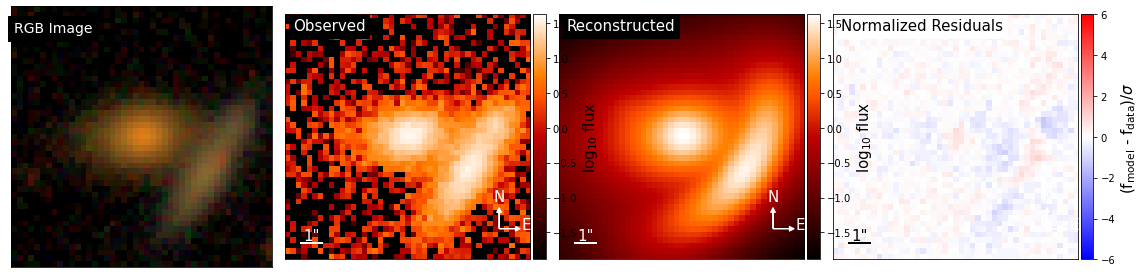

COADD_OBJECT_ID: 1515924344
The expected Einstein radius is 3.25687399  +-  0.4186183
The Einstein radius from the model is 3.4652894218869497


In [32]:
#COADD = 1515924344

model(coadd_id = 1515924344,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.18922099868040335 reduced X^2 of best position
-572.3935210082201 logL
6050 effective number of data points
[{'theta_E': 1.010637728096242, 'e1': -0.28311299649175764, 'e2': -0.49953710587138705, 'center_x': -0.3882935185972034, 'center_y': 0.6331646479510431}, {'gamma1': 0.07311688728047419, 'gamma2': 0.13161827246516797, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.8209921154718741, 'n_sersic': 0.6480996274056705, 'e1': -0.3497801229541466, 'e2': -0.19107034922748495, 'center_x': -0.2313859376851922, 'center_y': 0.04096670893201349}] source result
[{'amp': 1, 'R_sersic': 0.9119440965984675, 'n_sersic': 4.884711167063083, 'e1': -0.16782707796071078, 'e2': 0.03978636113349091, 'center_x': -0.09327521516428897, 'center_y': 0.40233865460501345}] lens light result
[] point source result
{} special param result
123.64609718322754 time used for  P

100%|████████████████████████████████████████████| 800/800 [07:43<00:00,  1.73it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
464.04402112960815 time taken for MCMC sampling
-0.1779656160563148 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.06357458825459611
reduced chi^2 of data  1 =  0.14199968539643698
reduced chi^2 of data  2 =  0.32832257451791136


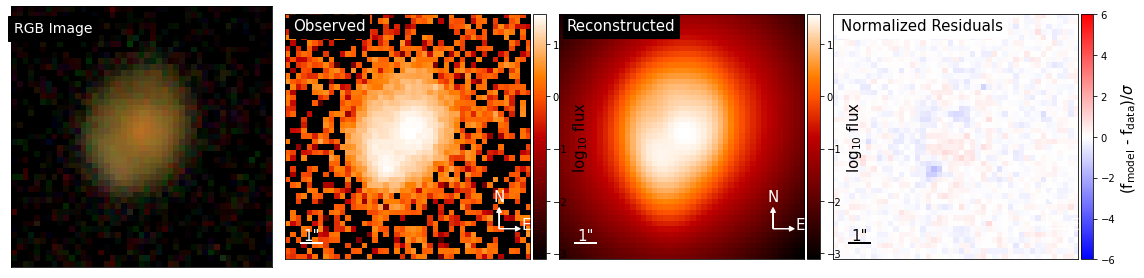

COADD_OBJECT_ID: 1098080005
The expected Einstein radius is 1.55755453  +-  0.30566119
The Einstein radius from the model is 1.3582918222863498


In [37]:
#COADD = 1098080005

# since Einstein radius is so much smaller I am using a new guess with the same initial parameters 
# but a smaller E

kwargs_lens_initial_sm = {'theta_E': 1.5, 'e1': 0.05, 'e2': -0.05,'center_x': 0., 'center_y': 0.}

model(coadd_id = 1098080005,
      kwargs_lens_initial = kwargs_lens_initial_sm, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.23868382754631504 reduced X^2 of best position
-722.018578327603 logL
6050 effective number of data points
[{'theta_E': 4.782133531545106, 'e1': -0.01359136373593508, 'e2': 0.06177109139899679, 'center_x': 0.27200574949866546, 'center_y': -0.5239193622104811}, {'gamma1': -0.07675188919428515, 'gamma2': -0.08248313711085882, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.22988353027524788, 'n_sersic': 0.501651926443111, 'e1': -0.0019262075199447128, 'e2': -0.29937887984831707, 'center_x': 0.6835926917255629, 'center_y': -1.5157654228107988}] source result
[{'amp': 1, 'R_sersic': 2.5404057515657303, 'n_sersic': 3.7760253655922034, 'e1': -0.14656945403754573, 'e2': -0.1230870717597644, 'center_x': 0.08123015803967167, 'center_y': -0.16785865913789205}] lens light result
[] point source result
{} special param result
129.37313890457153 time used fo

100%|████████████████████████████████████████████| 800/800 [37:47<00:00,  2.83s/it]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
2268.3496708869934 time taken for MCMC sampling
-0.22933340800550037 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.07779802714220116
reduced chi^2 of data  1 =  0.15352957445471452
reduced chi^2 of data  2 =  0.4566726224195855


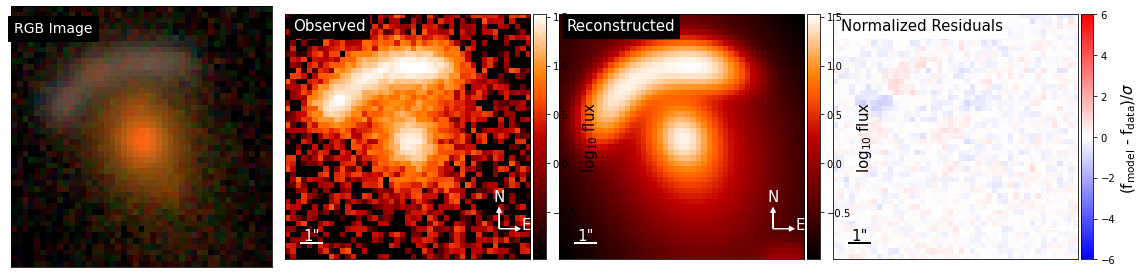

COADD_OBJECT_ID: 1196484135
The expected Einstein radius is 3.27381437  +-  0.41993762
The Einstein radius from the model is 5.374246537146067


In [34]:
#COADD = 1196484135

model(coadd_id = 1196484135,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.4560519281245573 reduced X^2 of best position
-1379.557082576786 logL
6050 effective number of data points
[{'theta_E': 3.7753133577495985, 'e1': 0.2614182719985341, 'e2': 0.16314350748495463, 'center_x': -0.519012627947308, 'center_y': 0.12003215657941174}, {'gamma1': -0.08812634362927609, 'gamma2': -0.1338502482092096, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.6961784464407142, 'n_sersic': 0.5763098946899848, 'e1': 0.2265751522269044, 'e2': 0.08393800429953485, 'center_x': 1.291292587577336, 'center_y': 0.45287163303189504}] source result
[{'amp': 1, 'R_sersic': 3.9735911569345204, 'n_sersic': 4.095306997897543, 'e1': 0.04630069714090322, 'e2': 0.03789441936053886, 'center_x': -0.2085878477622657, 'center_y': -0.07178890849308883}] lens light result
[] point source result
{} special param result
134.31506204605103 time used for  PSO


100%|████████████████████████████████████████████| 800/800 [08:46<00:00,  1.52it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
527.2005863189697 time taken for MCMC sampling
-0.4542758021563169 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.15598564679119625
reduced chi^2 of data  1 =  0.3660045802737639
reduced chi^2 of data  2 =  0.8408371794039904


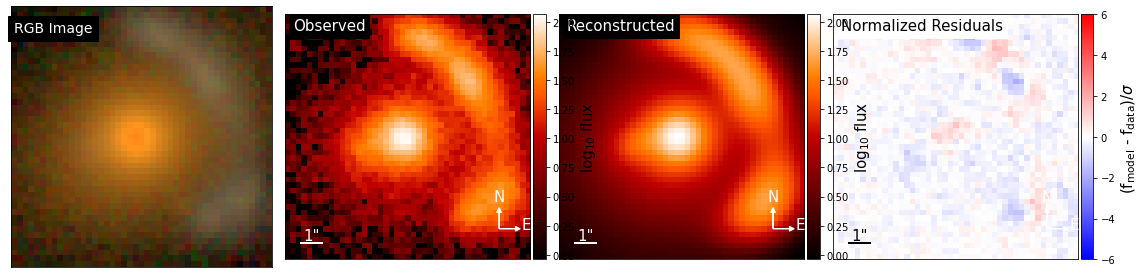

COADD_OBJECT_ID: 1186271916
The expected Einstein radius is 4.44462836  +-  0.46436402
The Einstein radius from the model is 3.8020933121734144


In [36]:
#COADD = 1186271916

model(coadd_id = 1186271916,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)
